In [1]:
import os
import sys
import cv2
import glob
import tqdm
import argparse
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
# Number of epochs to train the model for
epochs = 5
# Batch size
bs = 1
# Learning Rate
lr = 0.0002
# L2 Weight decay
wd = 0.0
# Image size to be used for training
img_size = 768
# Whether to use Image augmentation
aug = True
# Number of workers to use for loading data
n_worker = 2
# Number of epochs after which to test the weights
test_interval = 2
# Number of epochs after which to save the weights. If None, does not save
save_interval = 2
# Whether to save optimizer along with model weights or not
save_opt = False
# Logging interval (in #batches)
log_interval = 5    #250
# Path to the model to resume from
res_mod = '../input/archive1/best-model_epoch-204_mae-0.0505_loss-0.1370.pth'
# Path to the optimizer to resume from
res_opt = None
# Flag to use GPU or not
use_gpu = True
# Base path for the models to be saved
base_save_path = './models'
### Hyper-parameters for Loss
# weight for saliency loss
alpha_sal = 0.7
# w0 for weighted BCE Loss
wbce_w0 = 1.0
# w1 for weighted BCE Loss
wbce_w1 = 1.15

### Attention Network

In [3]:
class SpatialAttention(nn.Module):
    def __init__(self, in_channels, kernel_size=9):
        super(SpatialAttention, self).__init__()

        self.kernel_size = kernel_size
        self.in_channels = in_channels
        pad = (self.kernel_size-1)//2  # Padding on one side for stride 1

        self.grp1_conv1k = nn.Conv2d(self.in_channels, self.in_channels//2, (1, self.kernel_size), padding=(0, pad))
        self.grp1_bn1 = nn.BatchNorm2d(self.in_channels//2)
        self.grp1_convk1 = nn.Conv2d(self.in_channels//2, 1, (self.kernel_size, 1), padding=(pad, 0))
        self.grp1_bn2 = nn.BatchNorm2d(1)

        self.grp2_convk1 = nn.Conv2d(self.in_channels, self.in_channels//2, (self.kernel_size, 1), padding=(pad, 0))
        self.grp2_bn1 = nn.BatchNorm2d(self.in_channels//2)
        self.grp2_conv1k = nn.Conv2d(self.in_channels//2, 1, (1, self.kernel_size), padding=(0, pad))
        self.grp2_bn2 = nn.BatchNorm2d(1)

    def forward(self, input_):
        # Generate Group 1 Features
        grp1_feats = self.grp1_conv1k(input_)
        grp1_feats = F.relu(self.grp1_bn1(grp1_feats))
        grp1_feats = self.grp1_convk1(grp1_feats)
        grp1_feats = F.relu(self.grp1_bn2(grp1_feats))

        # Generate Group 2 features
        grp2_feats = self.grp2_convk1(input_)
        grp2_feats = F.relu(self.grp2_bn1(grp2_feats))
        grp2_feats = self.grp2_conv1k(grp2_feats)
        grp2_feats = F.relu(self.grp2_bn2(grp2_feats))

        added_feats = torch.sigmoid(torch.add(grp1_feats, grp2_feats))
        added_feats = added_feats.expand_as(input_).clone()

        return added_feats


class ChannelwiseAttention(nn.Module):
    def __init__(self, in_channels):
        super(ChannelwiseAttention, self).__init__()

        self.in_channels = in_channels

        self.linear_1 = nn.Linear(self.in_channels, self.in_channels//4)
        self.linear_2 = nn.Linear(self.in_channels//4, self.in_channels)

    def forward(self, input_):
        n_b, n_c, h, w = input_.size()

        feats = F.adaptive_avg_pool2d(input_, (1, 1)).view((n_b, n_c))
        feats = F.relu(self.linear_1(feats))
        feats = torch.sigmoid(self.linear_2(feats))
        
        # Activity regularizer
        ca_act_reg = torch.mean(feats)

        feats = feats.view((n_b, n_c, 1, 1))
        feats = feats.expand_as(input_).clone()

        return feats, ca_act_reg

### Utility Functions

In [4]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image, cmap='gray')
    plt.show()
    
    
def accuracy(y_pred, y_true):
    return (y_pred.round() == y_true).float().mean()


def precision(y_pred, y_true):
    return torch.mul(y_pred.round(), y_true).sum() / y_pred.round().sum()


def recall(y_pred, y_true):
    return torch.mul(y_pred.round(), y_true).sum() / y_true.sum()

### Get Dataloaders

In [5]:
def pad_resize_image(inp_img, out_img=None, target_size=None):
    """
    Function to pad and resize images to a given size.
    out_img is None only during inference. During training and testing
    out_img is NOT None.
    :param inp_img: A H x W x C input image.
    :param out_img: A H x W input image of mask.
    :param target_size: The size of the final images.
    :return: Re-sized inp_img and out_img
    """
    h, w, c = inp_img.shape
    size = max(h, w)

    padding_h = (size - h) // 2
    padding_w = (size - w) // 2

    if out_img is None:
        # For inference
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x
    else:
        # For training and testing
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        temp_y = cv2.copyMakeBorder(out_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        # print(inp_img.shape, temp_x.shape, out_img.shape, temp_y.shape)

        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
            temp_y = cv2.resize(temp_y, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x, temp_y


def random_crop_flip(inp_img, out_img):
    """
    Function to randomly crop and flip images.
    :param inp_img: A H x W x C input image.
    :param out_img: A H x W input image.
    :return: The randomly cropped and flipped image.
    """
    h, w = out_img.shape

    rand_h = np.random.randint(h/8)
    rand_w = np.random.randint(w/8)
    offset_h = 0 if rand_h == 0 else np.random.randint(rand_h)
    offset_w = 0 if rand_w == 0 else np.random.randint(rand_w)
    p0, p1, p2, p3 = offset_h, h+offset_h-rand_h, offset_w, w+offset_w-rand_w

    rand_flip = np.random.randint(10)
    if rand_flip >= 5:
        inp_img = inp_img[::, ::-1, ::]
        out_img = out_img[::, ::-1]

    return inp_img[p0:p1, p2:p3], out_img[p0:p1, p2:p3]


def random_rotate(inp_img, out_img, max_angle=25):
    """
    Function to randomly rotate images within +max_angle to -max_angle degrees.
    This algorithm does NOT crops the edges upon rotation.
    :param inp_img: A H x W x C input image.
    :param out_img: A H x W input image.
    :param max_angle: Maximum angle an image can be rotated in either direction.
    :return: The randomly rotated image.
    """
    angle = np.random.randint(-max_angle, max_angle)
    h, w = out_img.shape
    center = (w / 2, h / 2)

    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # Compute new dimensions of the image and adjust the rotation matrix
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))
    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]

    return cv2.warpAffine(inp_img, M, (new_w, new_h)), cv2.warpAffine(out_img, M, (new_w, new_h))


def random_rotate_lossy(inp_img, out_img, max_angle=25):
    """
    Function to randomly rotate images within +max_angle to -max_angle degrees.
    This algorithm crops the edges upon rotation.
    :param inp_img: A H x W x C input image.
    :param out_img: A H x W input image.
    :param max_angle: Maximum angle an image can be rotated in either direction.
    :return: The randomly rotated image.
    """
    angle = np.random.randint(-max_angle, max_angle)
    h, w = out_img.shape
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(inp_img, M, (w, h)), cv2.warpAffine(out_img, M, (w, h))


def random_brightness(inp_img):
    """
    Function to randomly perturb the brightness of the input images.
    :param inp_img: A H x W x C input image.
    :return: The image with randomly perturbed brightness.
    """
    contrast = np.random.rand(1) + 0.5
    light = np.random.randint(-20, 20)
    inp_img = contrast * inp_img + light

    return np.clip(inp_img, 0, 255)

In [6]:
class SODLoader(Dataset):
    """
    DataLoader for DUTS dataset (for training and testing).
    """
    def __init__(self, mode='train', augment_data=False, target_size=768):
        if mode == 'train':
            self.inp_path = '../input/mask-with-window/mask_with_window/images'
            self.out_path = '../input/mask-with-window/mask_with_window/mask'
        elif mode == 'test':
            self.inp_path = '../input/mask-with-window/mask_with_window/images'
            self.out_path = '../input/mask-with-window/mask_with_window/mask'
        else:
            print("mode should be either 'train' or 'test'.")
            sys.exit(0)

        self.augment_data = augment_data
        self.target_size = target_size
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            self.normalize,
        ])  # Not used

        self.inp_files = sorted(glob.glob(self.inp_path + '/*'))
        self.out_files = sorted(glob.glob(self.out_path + '/*'))

    def __getitem__(self, idx):
        inp_img = cv2.imread(self.inp_files[idx])
        inp_img = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)
        inp_img = inp_img.astype('float32')

        mask_img = cv2.imread(self.out_files[idx], 0)
        mask_img = mask_img.astype('float32')
        mask_img /= np.max(mask_img)

        if self.augment_data:
            inp_img, mask_img = random_crop_flip(inp_img, mask_img)
            inp_img, mask_img = random_rotate(inp_img, mask_img)
            inp_img = random_brightness(inp_img)

        # Pad images to target size
        inp_img, mask_img = pad_resize_image(inp_img, mask_img, self.target_size)
        inp_img /= 255.0
        inp_img = np.transpose(inp_img, axes=(2, 0, 1))
        inp_img = torch.from_numpy(inp_img).float()
        inp_img = self.normalize(inp_img)

        mask_img = np.expand_dims(mask_img, axis=0)

        return inp_img, torch.from_numpy(mask_img).float()

    def __len__(self):
        return len(self.inp_files)


class InfDataloader(Dataset):
    """
    Dataloader for Inference.
    """
    def __init__(self, img_folder, mask_folder, target_size=768):
        self.imgs_folder = img_folder
        self.img_paths = sorted(glob.glob(self.imgs_folder + '/*'))[:50]
        
        self.masks_folder = mask_folder
        self.mask_paths = sorted(glob.glob(self.masks_folder + '/*'))[:50]

        self.target_size = target_size
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    def __getitem__(self, idx):
        """
        __getitem__ for inference
        :param idx: Index of the image
        :return: img_np is a numpy RGB-image of shape H x W x C with pixel values in range 0-255.
        And img_tor is a torch tensor, RGB, C x H x W in shape and normalized.
        """
        img = cv2.imread(self.img_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        


        # Pad images to target size
        img_np = pad_resize_image(img, None, self.target_size)
        img_tor = img_np.astype(np.float32)
        img_tor = img_tor / 255.0
        img_tor = np.transpose(img_tor, axes=(2, 0, 1))
        img_tor = torch.from_numpy(img_tor).float()
        img_tor = self.normalize(img_tor)
        
        mask = cv2.imread(self.mask_paths[idx])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        


        # Pad images to target size
        mask_np = pad_resize_image(mask, None, self.target_size)
  
        

        return img_np, img_tor, mask_np

    def __len__(self):
        return len(self.img_paths) 
    


In [7]:
# Test Dataloader
img_size = 768
bs = 1

train_data = SODLoader(mode='train', augment_data=False, target_size=img_size)
test_data = SODLoader(mode='test', augment_data=False, target_size=img_size)

train_dataloader = DataLoader(train_data, batch_size=bs, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_data, batch_size=bs, shuffle=False, num_workers=2)

print("Train Dataloader :")
for batch_idx, (inp_imgs, gt_masks) in enumerate(train_dataloader):
    print('Loop :', batch_idx, inp_imgs.size(), gt_masks.size())
    if batch_idx == 3:
        break

print("\nTest Dataloader :")
for batch_idx, (inp_imgs, gt_masks) in enumerate(test_dataloader):
    print('Loop :', batch_idx, inp_imgs.size(), gt_masks.size())
    if batch_idx == 3:
        break



Train Dataloader :
Loop : 0 torch.Size([1, 3, 768, 768]) torch.Size([1, 1, 768, 768])
Loop : 1 torch.Size([1, 3, 768, 768]) torch.Size([1, 1, 768, 768])
Loop : 2 torch.Size([1, 3, 768, 768]) torch.Size([1, 1, 768, 768])
Loop : 3 torch.Size([1, 3, 768, 768]) torch.Size([1, 1, 768, 768])

Test Dataloader :
Loop : 0 torch.Size([1, 3, 768, 768]) torch.Size([1, 1, 768, 768])
Loop : 1 torch.Size([1, 3, 768, 768]) torch.Size([1, 1, 768, 768])
Loop : 2 torch.Size([1, 3, 768, 768]) torch.Size([1, 1, 768, 768])
Loop : 3 torch.Size([1, 3, 768, 768]) torch.Size([1, 1, 768, 768])


### Saliency Loss

In [8]:
class EdgeSaliencyLoss(nn.Module):
    def __init__(self, device, alpha_sal=0.7):
        super(EdgeSaliencyLoss, self).__init__()

        self.alpha_sal = alpha_sal

        self.laplacian_kernel = torch.tensor([[-1., -1., -1.], [-1., 8., -1.], [-1., -1., -1.]], dtype=torch.float, requires_grad=False)
        self.laplacian_kernel = self.laplacian_kernel.view((1, 1, 3, 3))  # Shape format of weight for convolution
        self.laplacian_kernel = self.laplacian_kernel.to(device)

    @staticmethod
    def weighted_bce(input_, target, weight_0=1.0, weight_1=1.0, eps=1e-15):
        wbce_loss = -weight_1 * target * torch.log(input_ + eps) - weight_0 * (1 - target) * torch.log(
            1 - input_ + eps)
        return torch.mean(wbce_loss)

    def forward(self, y_pred, y_gt):
        # Generate edge maps
        y_gt_edges = F.relu(torch.tanh(F.conv2d(y_gt, self.laplacian_kernel, padding=(1, 1))))
        y_pred_edges = F.relu(torch.tanh(F.conv2d(y_pred, self.laplacian_kernel, padding=(1, 1))))

        # sal_loss = F.binary_cross_entropy(input=y_pred, target=y_gt)
        sal_loss = self.weighted_bce(input_=y_pred, target=y_gt, weight_0=1.0, weight_1=1.12)
        edge_loss = F.binary_cross_entropy(input=y_pred_edges, target=y_gt_edges)

        total_loss = self.alpha_sal * sal_loss + (1 - self.alpha_sal) * edge_loss
        return total_loss


### Model Definition

In [9]:
vgg_conv1_2 = vgg_conv2_2 = vgg_conv3_3 = vgg_conv4_3 = vgg_conv5_3 = None


def conv_1_2_hook(module, input, output):
    global vgg_conv1_2
    vgg_conv1_2 = output
    return None


def conv_2_2_hook(module, input, output):
    global vgg_conv2_2
    vgg_conv2_2 = output
    return None


def conv_3_3_hook(module, input, output):
    global vgg_conv3_3
    vgg_conv3_3 = output
    return None


def conv_4_3_hook(module, input, output):
    global vgg_conv4_3
    vgg_conv4_3 = output
    return None


def conv_5_3_hook(module, input, output):
    global vgg_conv5_3
    vgg_conv5_3 = output
    return None


class CPFE(nn.Module):
    def __init__(self, feature_layer=None, out_channels=32):
        super(CPFE, self).__init__()

        self.dil_rates = [3, 5, 7]

        # Determine number of in_channels from VGG-16 feature layer
        if feature_layer == 'conv5_3':
            self.in_channels = 512
        elif feature_layer == 'conv4_3':
            self.in_channels = 512
        elif feature_layer == 'conv3_3':
            self.in_channels = 256

        # Define layers
        self.conv_1_1 = nn.Conv2d(in_channels=self.in_channels, out_channels=out_channels, kernel_size=1, bias=False)
        self.conv_dil_3 = nn.Conv2d(in_channels=self.in_channels, out_channels=out_channels, kernel_size=3,
                                    stride=1, dilation=self.dil_rates[0], padding=self.dil_rates[0], bias=False)
        self.conv_dil_5 = nn.Conv2d(in_channels=self.in_channels, out_channels=out_channels, kernel_size=3,
                                    stride=1, dilation=self.dil_rates[1], padding=self.dil_rates[1], bias=False)
        self.conv_dil_7 = nn.Conv2d(in_channels=self.in_channels, out_channels=out_channels, kernel_size=3,
                                    stride=1, dilation=self.dil_rates[2], padding=self.dil_rates[2], bias=False)

        self.bn = nn.BatchNorm2d(out_channels*4)

    def forward(self, input_):
        # Extract features
        conv_1_1_feats = self.conv_1_1(input_)
        conv_dil_3_feats = self.conv_dil_3(input_)
        conv_dil_5_feats = self.conv_dil_5(input_)
        conv_dil_7_feats = self.conv_dil_7(input_)

        # Aggregate features
        concat_feats = torch.cat((conv_1_1_feats, conv_dil_3_feats, conv_dil_5_feats, conv_dil_7_feats), dim=1)
        bn_feats = F.relu(self.bn(concat_feats))

        return bn_feats


class SODModel(nn.Module):
    def __init__(self):
        super(SODModel, self).__init__()

        # Load the [partial] VGG-16 model
        self.vgg16 = models.vgg16(pretrained=True).features

        # Extract and register intermediate features of VGG-16
        self.vgg16[3].register_forward_hook(conv_1_2_hook)
        self.vgg16[8].register_forward_hook(conv_2_2_hook)
        self.vgg16[15].register_forward_hook(conv_3_3_hook)
        self.vgg16[22].register_forward_hook(conv_4_3_hook)
        self.vgg16[29].register_forward_hook(conv_5_3_hook)

        # Initialize layers for high level (hl) feature (conv3_3, conv4_3, conv5_3) processing
        self.cpfe_conv3_3 = CPFE(feature_layer='conv3_3')
        self.cpfe_conv4_3 = CPFE(feature_layer='conv4_3')
        self.cpfe_conv5_3 = CPFE(feature_layer='conv5_3')

        self.cha_att = ChannelwiseAttention(in_channels=384)  # in_channels = 3 x (32 x 4)

        self.hl_conv1 = nn.Conv2d(384, 64, (3, 3), padding=1)
        self.hl_bn1 = nn.BatchNorm2d(64)

        # Initialize layers for low level (ll) feature (conv1_2 and conv2_2) processing
        self.ll_conv_1 = nn.Conv2d(64, 64, (3, 3), padding=1)
        self.ll_bn_1 = nn.BatchNorm2d(64)
        self.ll_conv_2 = nn.Conv2d(128, 64, (3, 3), padding=1)
        self.ll_bn_2 = nn.BatchNorm2d(64)
        self.ll_conv_3 = nn.Conv2d(128, 64, (3, 3), padding=1)
        self.ll_bn_3 = nn.BatchNorm2d(64)

        self.spa_att = SpatialAttention(in_channels=64)

        # Initialize layers for fused features (ff) processing
        self.ff_conv_1 = nn.Conv2d(128, 1, (3, 3), padding=1)

    def forward(self, input_):
        global vgg_conv1_2, vgg_conv2_2, vgg_conv3_3, vgg_conv4_3, vgg_conv5_3

        # Pass input_ through vgg16 to generate intermediate features
        self.vgg16(input_)

        # Process high level features
        conv3_cpfe_feats = self.cpfe_conv3_3(vgg_conv3_3)
        conv4_cpfe_feats = self.cpfe_conv4_3(vgg_conv4_3)
        conv5_cpfe_feats = self.cpfe_conv5_3(vgg_conv5_3)

        conv4_cpfe_feats = F.interpolate(conv4_cpfe_feats, scale_factor=2, mode='bilinear', align_corners=True)
        conv5_cpfe_feats = F.interpolate(conv5_cpfe_feats, scale_factor=4, mode='bilinear', align_corners=True)

        conv_345_feats = torch.cat((conv3_cpfe_feats, conv4_cpfe_feats, conv5_cpfe_feats), dim=1)

        conv_345_ca, ca_act_reg = self.cha_att(conv_345_feats)
        conv_345_feats = torch.mul(conv_345_feats, conv_345_ca)

        conv_345_feats = self.hl_conv1(conv_345_feats)
        conv_345_feats = F.relu(self.hl_bn1(conv_345_feats))
        conv_345_feats = F.interpolate(conv_345_feats, scale_factor=4, mode='bilinear', align_corners=True)

        # Process low level features
        conv1_feats = self.ll_conv_1(vgg_conv1_2)
        conv1_feats = F.relu(self.ll_bn_1(conv1_feats))
        conv2_feats = self.ll_conv_2(vgg_conv2_2)
        conv2_feats = F.relu(self.ll_bn_2(conv2_feats))

        conv2_feats = F.interpolate(conv2_feats, scale_factor=2, mode='bilinear', align_corners=True)
        conv_12_feats = torch.cat((conv1_feats, conv2_feats), dim=1)
        conv_12_feats = self.ll_conv_3(conv_12_feats)
        conv_12_feats = F.relu(self.ll_bn_3(conv_12_feats))

        conv_12_sa = self.spa_att(conv_345_feats)
        conv_12_feats = torch.mul(conv_12_feats, conv_12_sa)

        # Fused features
        fused_feats = torch.cat((conv_12_feats, conv_345_feats), dim=1)
        fused_feats = torch.sigmoid(self.ff_conv_1(fused_feats))

        return fused_feats, ca_act_reg

## Training

In [10]:
class Engine:
    def __init__(self):
        self.epochs = epochs
        self.bs = bs
        self.lr = lr
        self.wd = wd
        self.img_size = img_size
        self.aug = aug
        self.n_worker = n_worker
        self.test_interval = test_interval
        self.save_interval = save_interval
        self.save_opt = save_opt
        self.log_interval = log_interval
        self.res_mod_path = res_mod
        self.res_opt_path = res_opt
        self.use_gpu = use_gpu

        self.alpha_sal = alpha_sal
        self.wbce_w0 = wbce_w0
        self.wbce_w1 = wbce_w1

        self.model_path = base_save_path + '/alph-{}_wbce_w0-{}_w1-{}'.format(str(self.alpha_sal), str(self.wbce_w0), str(self.wbce_w1))
        print('Models would be saved at : {}\n'.format(self.model_path))
        if not os.path.exists(os.path.join(self.model_path, 'weights')):
            os.makedirs(os.path.join(self.model_path, 'weights'))
        if not os.path.exists(os.path.join(self.model_path, 'optimizers')):
            os.makedirs(os.path.join(self.model_path, 'optimizers'))

        if torch.cuda.is_available():
            self.device = torch.device(device='cuda')
        else:
            self.device = torch.device(device='cpu')

        self.model = SODModel()
        self.model.to(self.device)
        self.criterion = EdgeSaliencyLoss(device=self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.wd)

        # Load model and optimizer if resumed
        if self.res_mod_path is not None:
            chkpt = torch.load(self.res_mod_path, map_location=self.device)
            self.model.load_state_dict(chkpt['model'])
            print("Resuming training with checkpoint : {}\n".format(self.res_mod_path))
        if self.res_opt_path is not None:
            chkpt = torch.load(self.res_opt_path, map_location=self.device)
            self.optimizer.load_state_dict(chkpt['optimizer'])
            print("Resuming training with optimizer : {}\n".format(self.res_opt_path))

        self.train_data = SODLoader(mode='train', augment_data=self.aug, target_size=self.img_size)
        self.test_data = SODLoader(mode='test', augment_data=False, target_size=self.img_size)
        self.train_dataloader = DataLoader(self.train_data, batch_size=self.bs, shuffle=True, num_workers=self.n_worker)
        self.test_dataloader = DataLoader(self.test_data, batch_size=self.bs, shuffle=False, num_workers=self.n_worker)

    def train(self):
        best_test_mae = float('inf')
        for epoch in range(self.epochs):
            self.model.train()
            for batch_idx, (inp_imgs, gt_masks) in enumerate(self.train_dataloader):
                inp_imgs = inp_imgs.to(self.device)
                gt_masks = gt_masks.to(self.device)

                self.optimizer.zero_grad()
                pred_masks, ca_act_reg = self.model(inp_imgs)
                loss = self.criterion(pred_masks, gt_masks) + ca_act_reg  # Activity regularizer from Channel-wise Att.

                loss.backward()
                self.optimizer.step()

                if batch_idx % self.log_interval == 0:
                    print('\rTRAIN :: Epoch : {}\tBatch : {}/{} ({:.2f}%)\t\tTot Loss : {:.4f}\tReg : {:.4f}'
                          .format(epoch + 1,
                                  batch_idx + 1, len(self.train_dataloader),
                                  (batch_idx + 1) * 100 / len(self.train_dataloader),
                                  loss.item(),
                                  ca_act_reg), 
                                  end='', flush=True)

            # Validation
            if epoch % self.test_interval == 0 or epoch % self.save_interval == 0:
                te_avg_loss, te_acc, te_pre, te_rec, te_mae = self.test()
                mod_chkpt = {'epoch': epoch,
                            'test_mae' : float(te_mae),
                            'model' : self.model.state_dict(),
                            'test_loss': float(te_avg_loss),
                            'test_acc': float(te_acc),
                            'test_pre': float(te_pre),
                            'test_rec': float(te_rec)}

                if self.save_opt:
                    opt_chkpt = {'epoch': epoch,
                                'test_mae' : float(te_mae),
                                'optimizer': self.optimizer.state_dict(),
                                'test_loss': float(te_avg_loss),
                                'test_acc': float(te_acc),
                                'test_pre': float(te_pre),
                                'test_rec': float(te_rec)}

                # Save the best model
                if te_mae < best_test_mae:
                    best_test_mae = te_mae
                    torch.save(mod_chkpt, self.model_path + '/weights/best-model_epoch-{:03}_mae-{:.4f}_loss-{:.4f}.pth'.
                               format(epoch, best_test_mae, te_avg_loss))
                    if self.save_opt:
                        torch.save(opt_chkpt, self.model_path + '/optimizers/best-opt_epoch-{:03}_mae-{:.4f}_loss-{:.4f}.pth'.
                                   format(epoch, best_test_mae, te_avg_loss))
                    print('Best Model Saved !!!\n')
                    continue
                
                # Save model at regular intervals
                if self.save_interval is not None and epoch % self.save_interval == 0:
                    torch.save(mod_chkpt, self.model_path + '/weights/model_epoch-{:03}_mae-{:.4f}_loss-{:.4f}.pth'.
                               format(epoch, te_mae, te_avg_loss))
                    if self.save_opt:
                        torch.save(opt_chkpt, self.model_path + '/optimizers/opt_epoch-{:03}_mae-{:.4f}_loss-{:.4f}.pth'.
                                   format(epoch, best_test_mae, te_avg_loss))
                    print('Model Saved !!!\n')
                    continue
            print('\n')

    def test(self):
        self.model.eval()

        tot_loss = 0
        tp_fp = 0   # TruePositive + TrueNegative, for accuracy
        tp = 0      # TruePositive
        pred_true = 0   # Number of '1' predictions, for precision
        gt_true = 0     # Number of '1's in gt mask, for recall
        mae_list = []   # List to save mean absolute error of each image

        with torch.no_grad():
            for batch_idx, (inp_imgs, gt_masks) in enumerate(self.test_dataloader, start=1):
                inp_imgs = inp_imgs.to(self.device)
                gt_masks = gt_masks.to(self.device)

                pred_masks, ca_act_reg = self.model(inp_imgs)
                loss = self.criterion(pred_masks, gt_masks) + ca_act_reg

                tot_loss += loss.item()

                tp_fp += (pred_masks.round() == gt_masks).float().sum()
                tp += torch.mul(pred_masks.round(), gt_masks).sum()
                pred_true += pred_masks.round().sum()
                gt_true += gt_masks.sum()

                # Record the absolute errors
                ae = torch.mean(torch.abs(pred_masks - gt_masks), dim=(1, 2, 3)).cpu().numpy()
                mae_list.extend(ae)

        avg_loss = tot_loss / batch_idx
        accuracy = tp_fp / (len(self.test_data) * self.img_size * self.img_size)
        precision = tp / pred_true
        recall = tp / gt_true
        mae = np.mean(mae_list)

        print('\rTEST :: MAE : {:.4f}\tACC : {:.4f}\tPRE : {:.4f}\tREC : {:.4f}\tAVG-LOSS : {:.4f}\n'.format(mae,
                                                                                             accuracy, precision,
                                                                                             recall, avg_loss), 
                                                                                             end='', flush=True)

        return avg_loss, accuracy, precision, recall, mae

In [11]:
# Driver class
trainer = Engine()
trainer.train()
trainer.test()

Models would be saved at : ./models/alph-0.7_wbce_w0-1.0_w1-1.15



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Resuming training with checkpoint : ../input/archive1/best-model_epoch-204_mae-0.0505_loss-0.1370.pth

TEST :: MAE : 0.0293	ACC : 0.9608	PRE : 0.9505	REC : 0.9824	AVG-LOSS : 0.0621
Best Model Saved !!!

TRAIN :: Epoch : 2	Batch : 4861/4865 (99.92%)		Tot Loss : 0.0514	Reg : 0.0004

TEST :: MAE : 0.0193	ACC : 0.9648	PRE : 0.9626	REC : 0.9868	AVG-LOSS : 0.0491
Best Model Saved !!!

TRAIN :: Epoch : 4	Batch : 4861/4865 (99.92%)		Tot Loss : 0.0487	Reg : 0.0002

TEST :: MAE : 0.0167	ACC : 0.9665	PRE : 0.9697	REC : 0.9866	AVG-LOSS : 0.0459
Best Model Saved !!!

TEST :: MAE : 0.0167	ACC : 0.9665	PRE : 0.9697	REC : 0.9866	AVG-LOSS : 0.0459


(0.04594962568159185,
 tensor(0.9665, device='cuda:0'),
 tensor(0.9697, device='cuda:0'),
 tensor(0.9866, device='cuda:0'),
 0.016656782)

## Inference

In [12]:
# Path to folder containing images
imgs_folder = '../input/mask-with-window/mask_with_window/images'
masks_folder = '../input/mask-with-window/mask_with_window/mask'
# Path to model
model_path = sorted(glob.glob('./models/alph-0.7_wbce_w0-1.0_w1-1.15/weights/best-model_epoch-*'), reverse=True)[0]
# Whether to use GPU or not
use_gpu = True
# Image size to be used
img_size = 768
mask_size = 768
# Batch Size for testing
bs = 1

sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [13]:
def run_inference():
    # Determine device
    if use_gpu and torch.cuda.is_available():
        device = torch.device(device='cuda')
    else:
        device = torch.device(device='cpu')

    # Load model
    model = SODModel()
    chkpt = torch.load(model_path, map_location=device)
    model.load_state_dict(chkpt['model'])
    model.to(device)
    model.eval()

    inf_data = InfDataloader(img_folder=imgs_folder, mask_folder=masks_folder, target_size=img_size)
    # Since the images would be displayed to the user, the batch_size is set to 1
    # Code at later point is also written assuming batch_size = 1, so do not change
    inf_dataloader = DataLoader(inf_data, batch_size=1, shuffle=True, num_workers=2)
    
    with torch.no_grad():
        for batch_idx, (img_np, img_tor, mask_np) in enumerate(inf_dataloader, start=1):
            img_tor = img_tor.to(device)
            pred_masks, _ = model(img_tor)

            # Assuming batch_size = 1
            img_np = np.squeeze(img_np.numpy(), axis=0)
            img_np = img_np.astype(np.uint8)
            pred_masks_raw = np.squeeze(pred_masks.cpu().numpy(), axis=(0, 1))
            pred_masks_round = np.squeeze(pred_masks.round().cpu().numpy(), axis=(0, 1))
        
            mask_np = np.squeeze(mask_np.numpy(), axis=0)
            mask_np = mask_np.astype(np.uint8)
            
            visualize(
                input_image = img_np,
                ground_truth_mask_ = mask_np,
                generated_map = pred_masks_raw,
                rounded_off_generated_map = pred_masks_round,
            )
            

def calculate_mae():
    # Determine device
    if use_gpu and torch.cuda.is_available():
        device = torch.device(device='cuda')
    else:
        device = torch.device(device='cpu')

    # Load model
    model = SODModel()
    chkpt = torch.load(model_path, map_location=device)
    model.load_state_dict(chkpt['model'])
    model.to(device)
    model.eval()

    test_data = SODLoader(mode='test', augment_data=False, target_size=img_size)
    test_dataloader = DataLoader(test_data, batch_size=bs, shuffle=False, num_workers=2)

    # List to save mean absolute error of each image
    mae_list = []
    with torch.no_grad():
        for batch_idx, (inp_imgs, gt_masks) in enumerate(tqdm.tqdm(test_dataloader), start=1):
            inp_imgs = inp_imgs.to(device)
            gt_masks = gt_masks.to(device)
            pred_masks, _ = model(inp_imgs)

            mae = torch.mean(torch.abs(pred_masks - gt_masks), dim=(1, 2, 3)).cpu().numpy()
            mae_list.extend(mae)

    print('MAE for the test set is :', np.mean(mae_list))


100%|██████████| 4865/4865 [08:13<00:00,  9.85it/s]


MAE for the test set is : 0.016656782


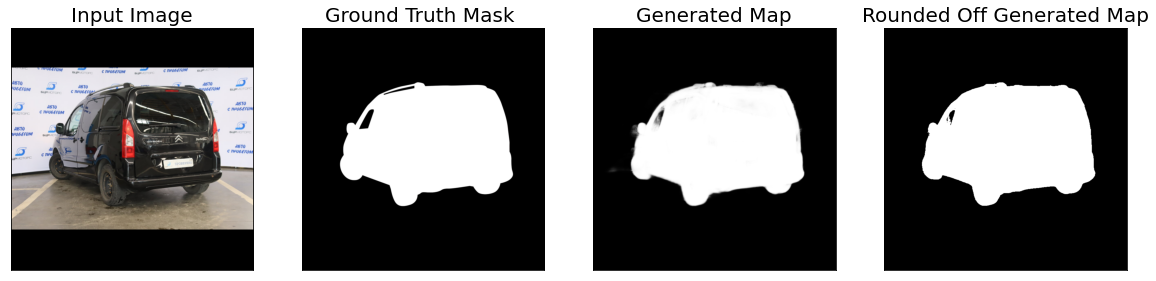

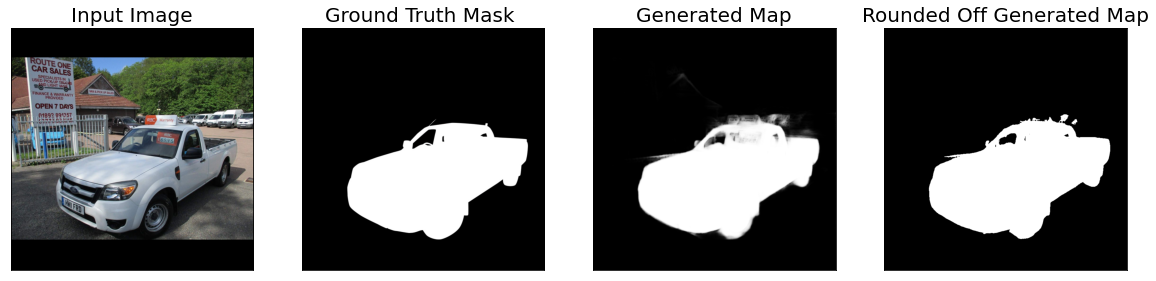

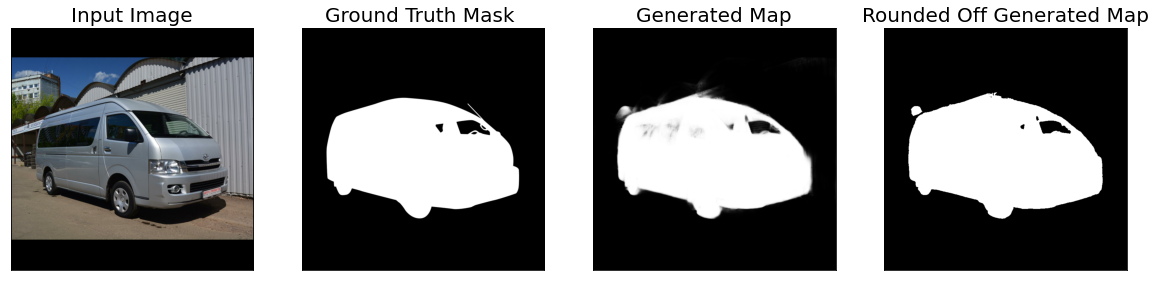

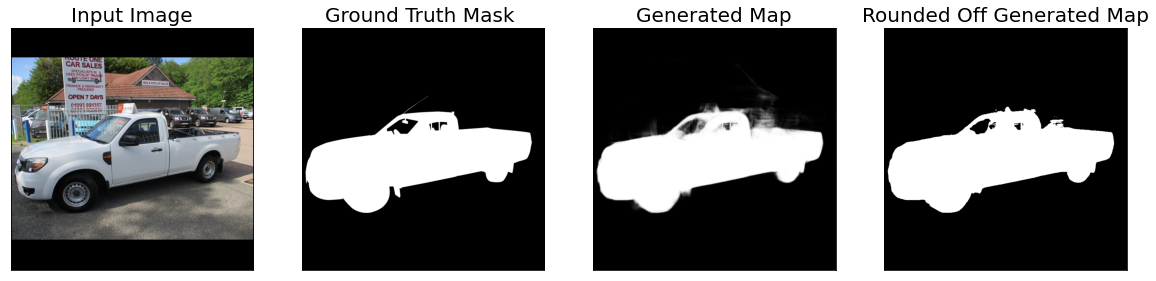

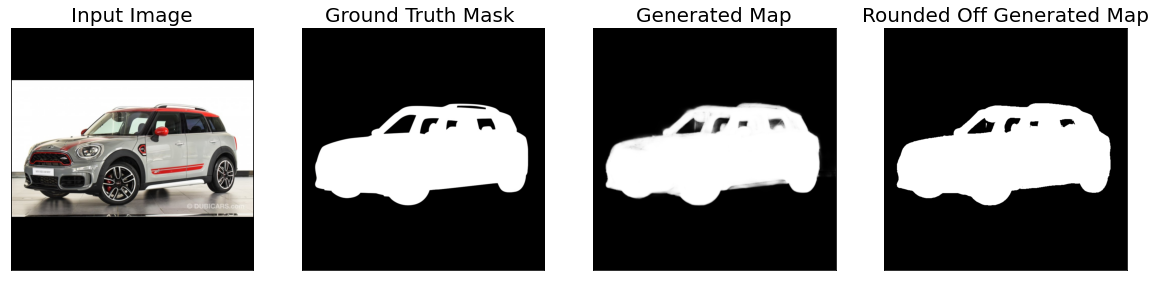

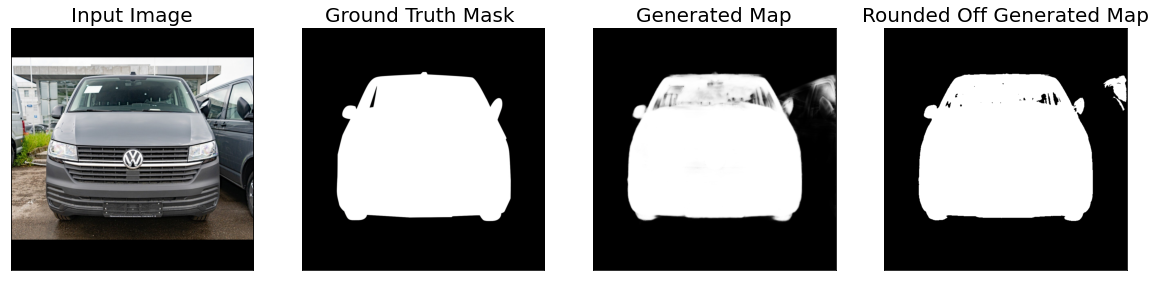

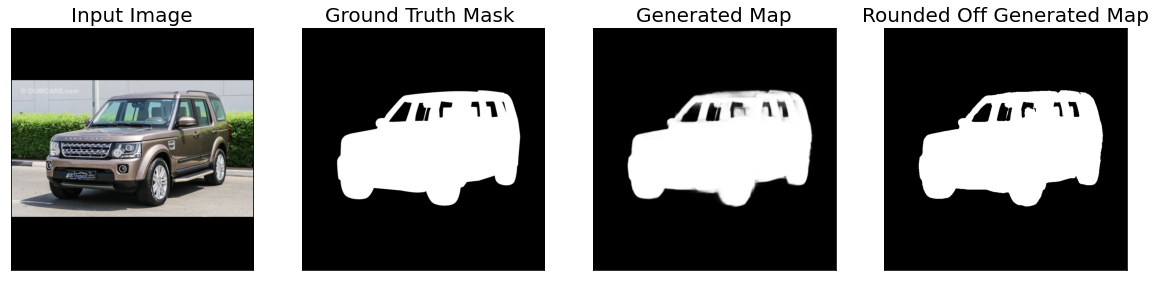

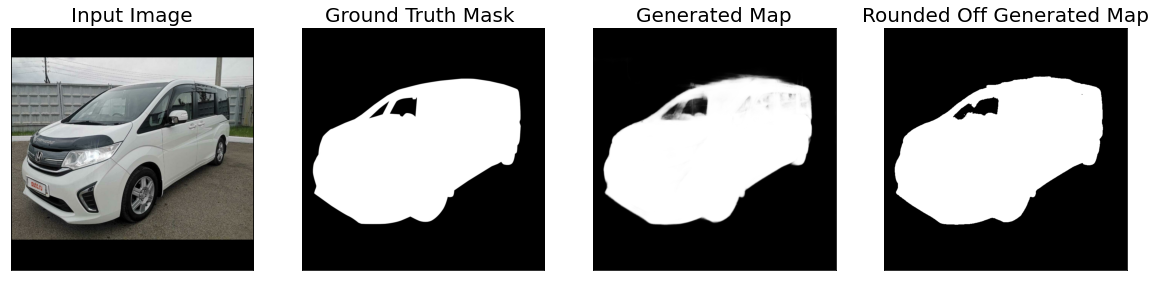

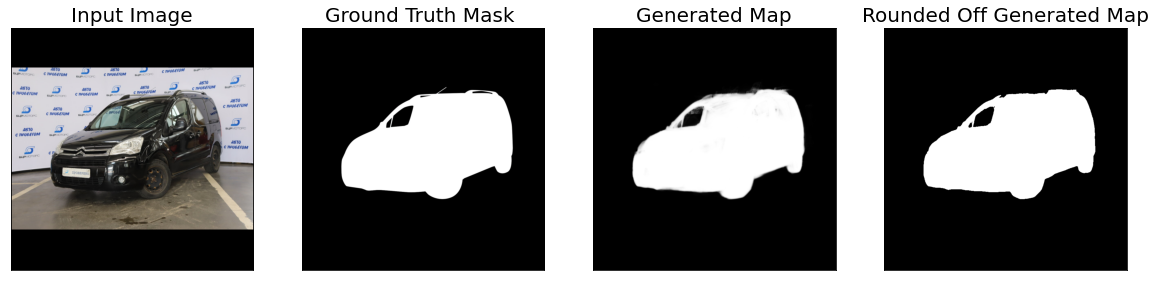

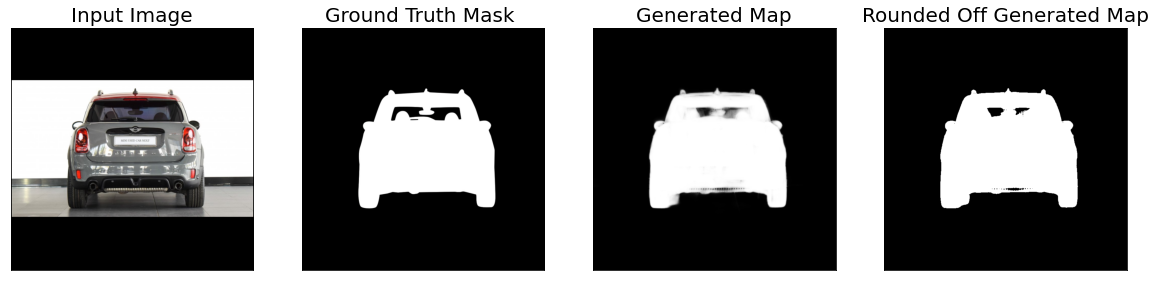

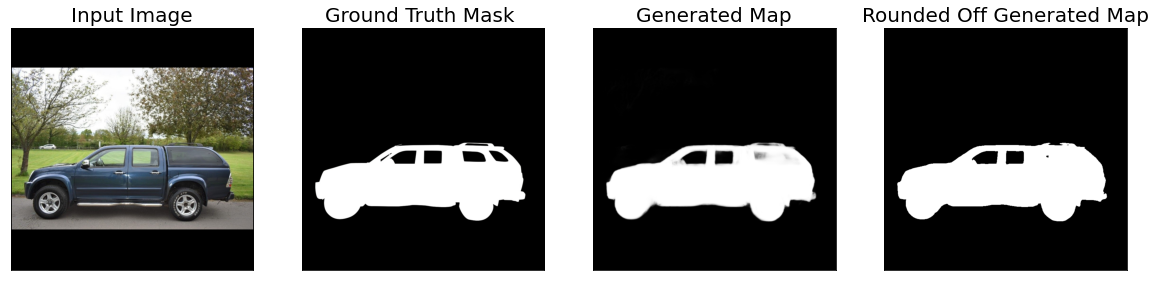

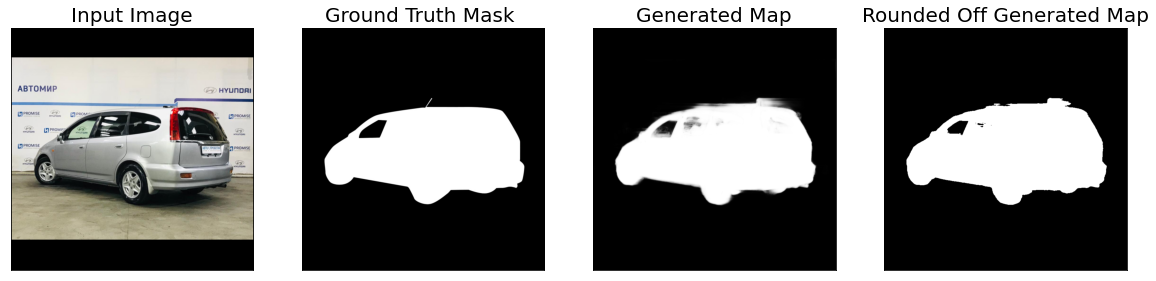

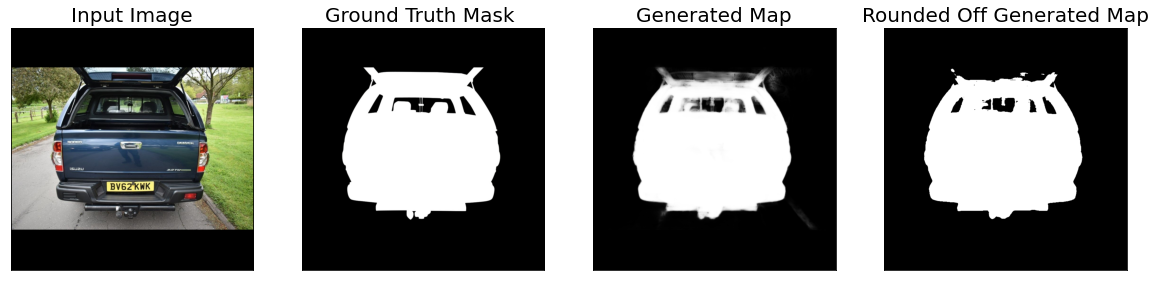

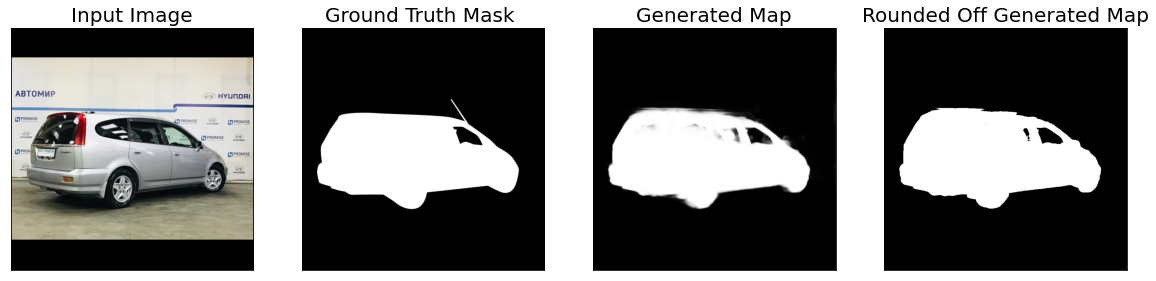

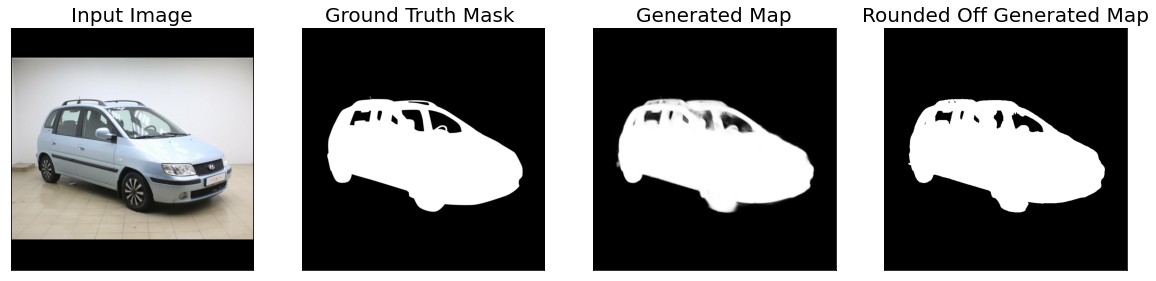

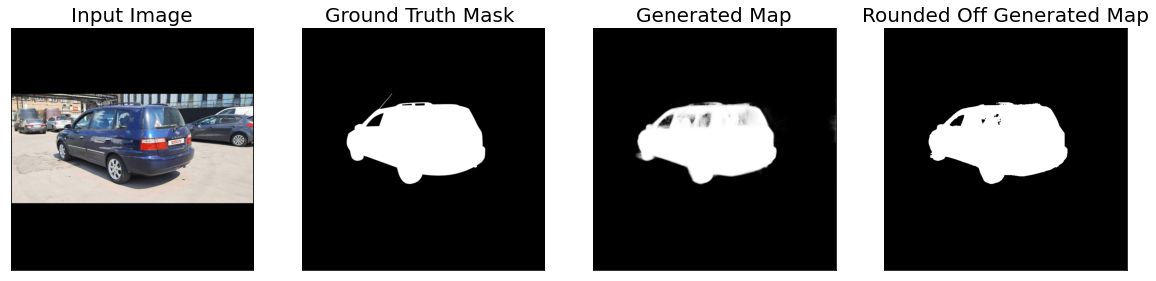

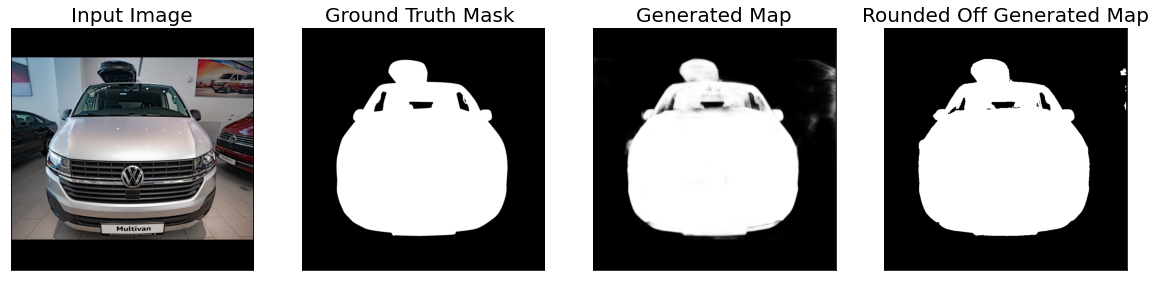

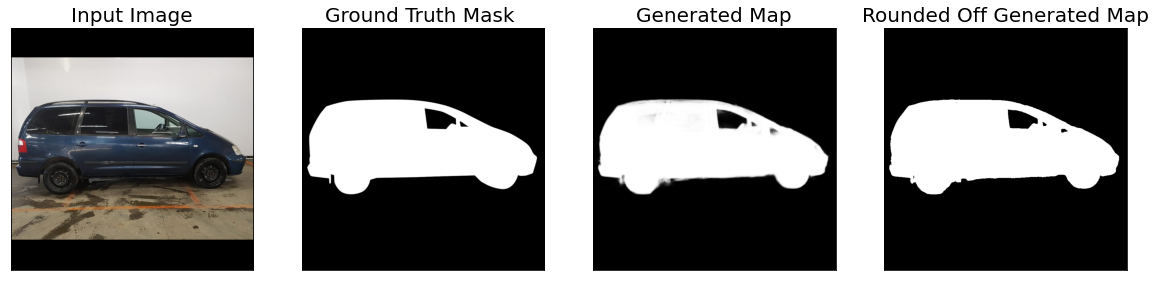

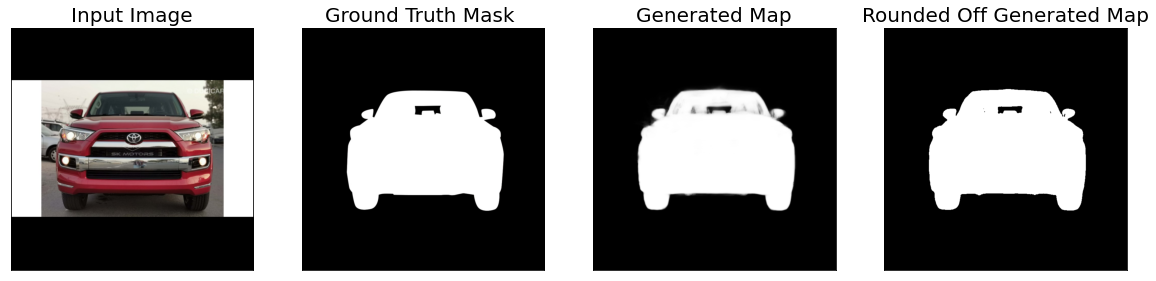

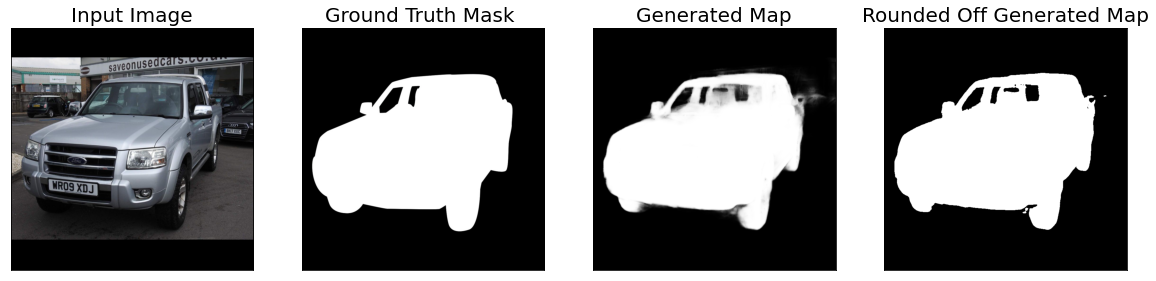

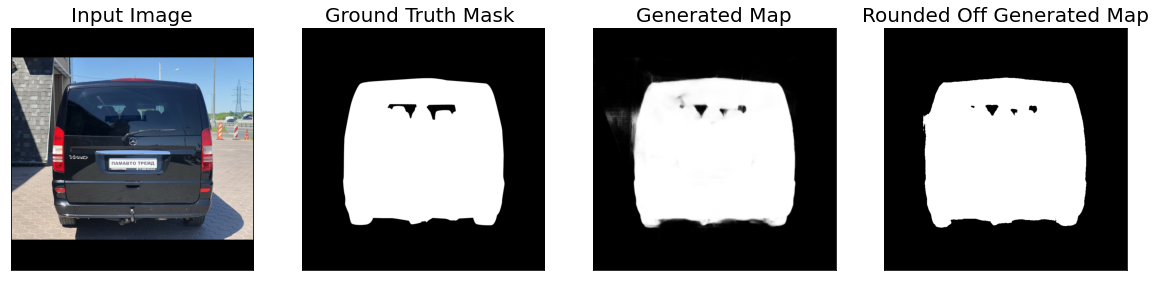

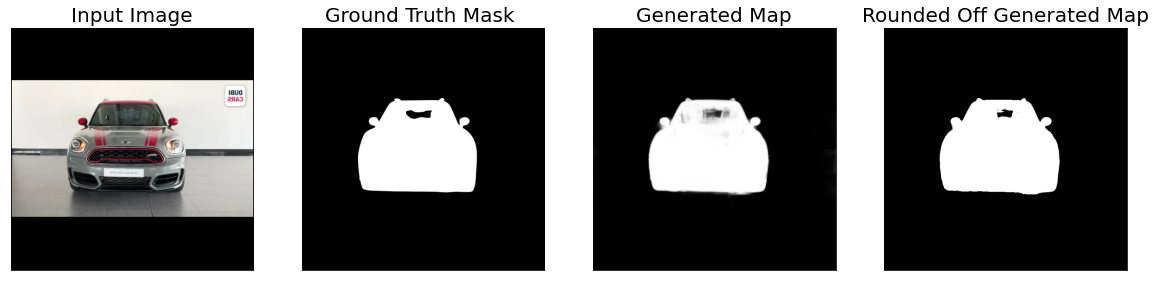

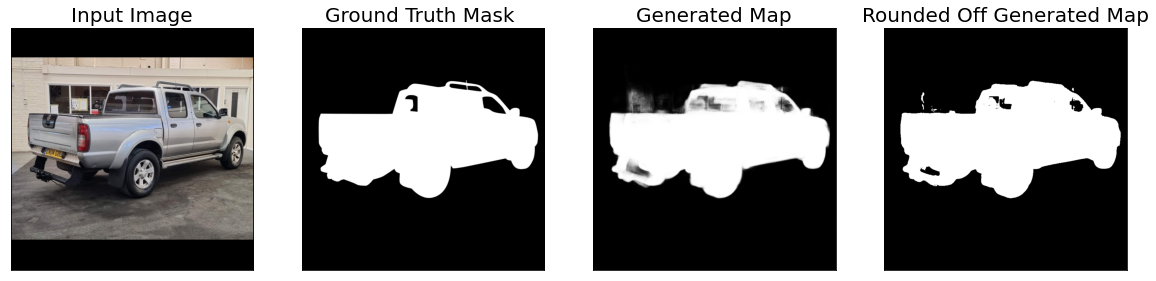

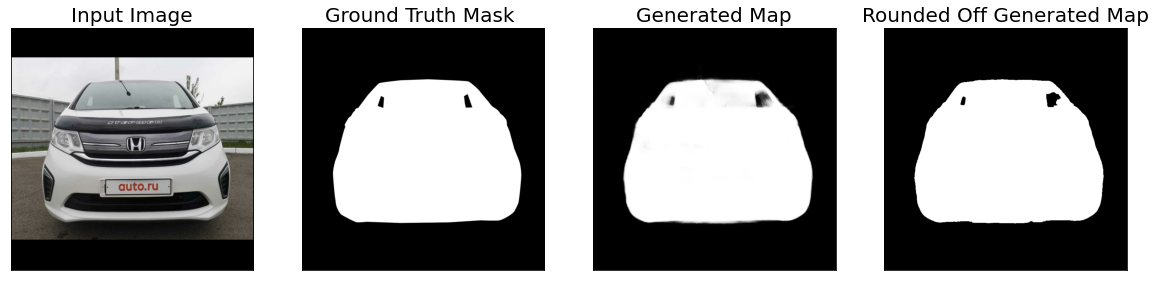

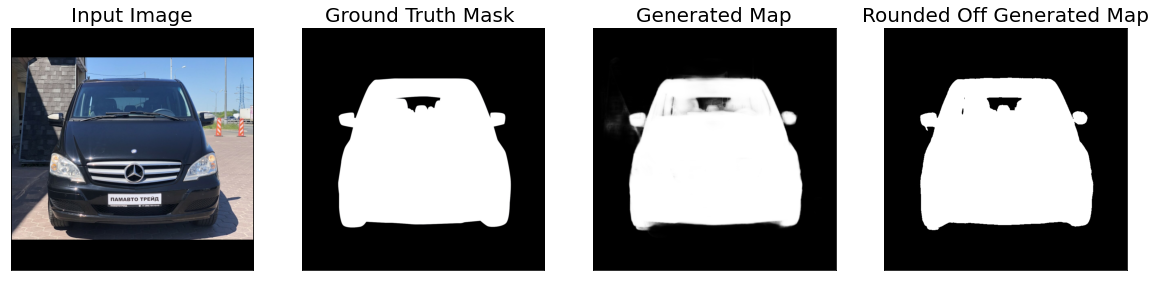

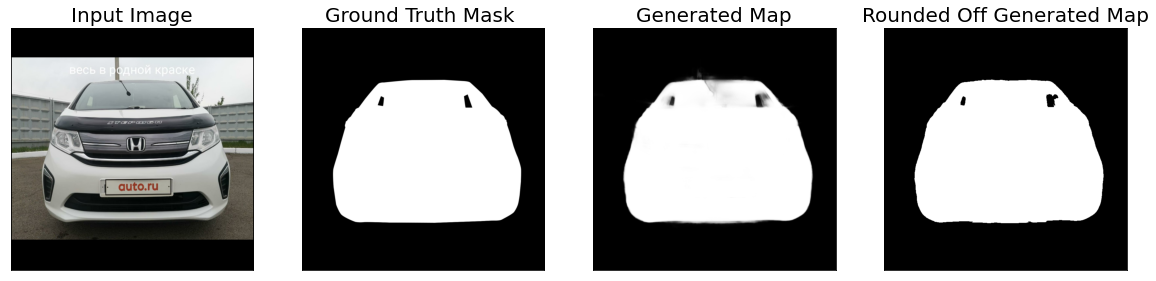

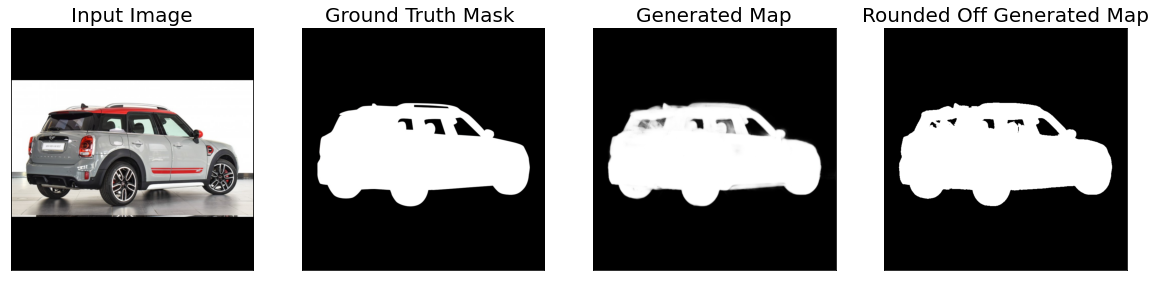

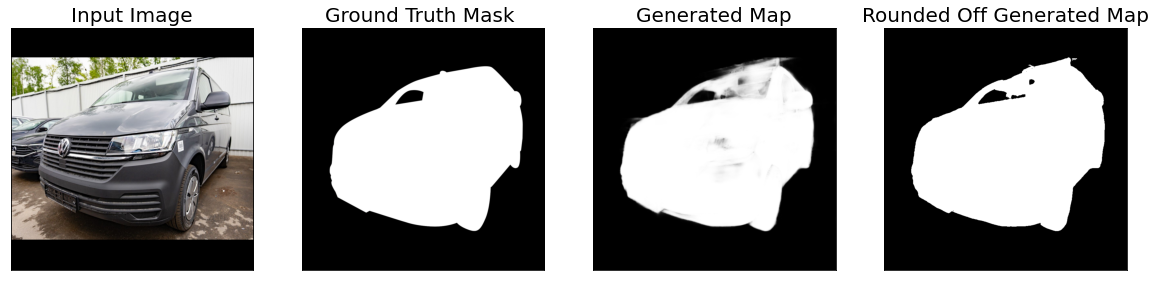

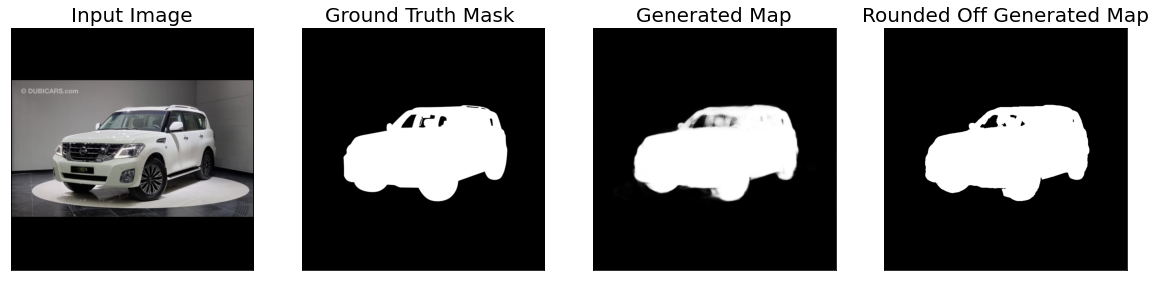

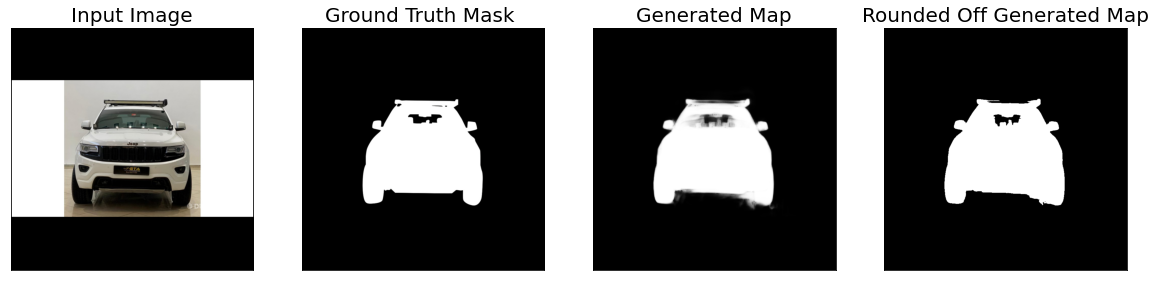

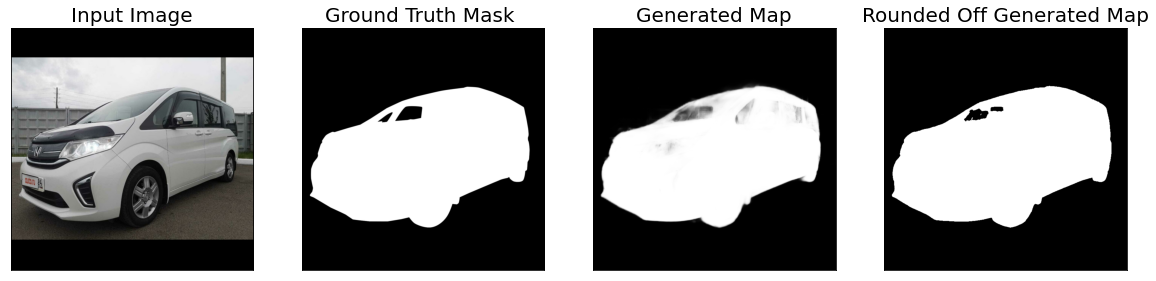

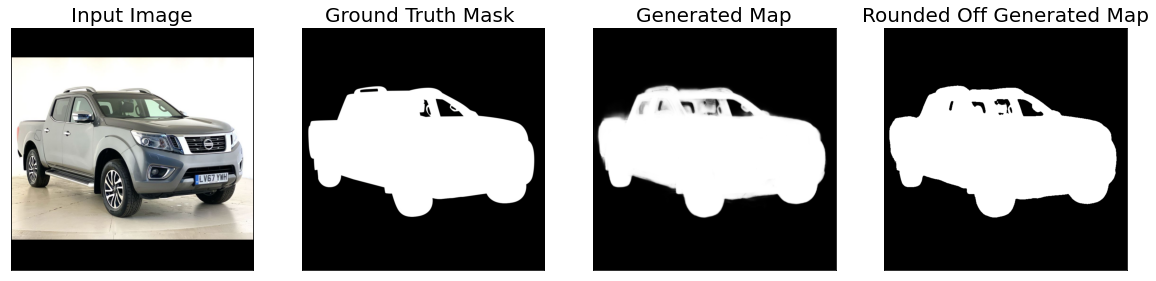

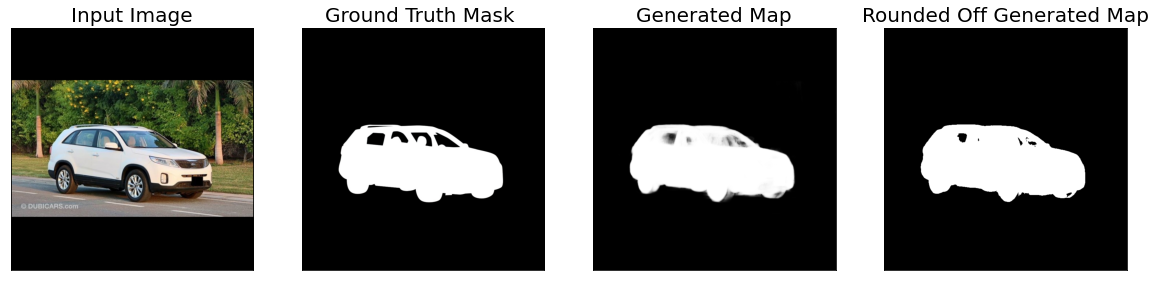

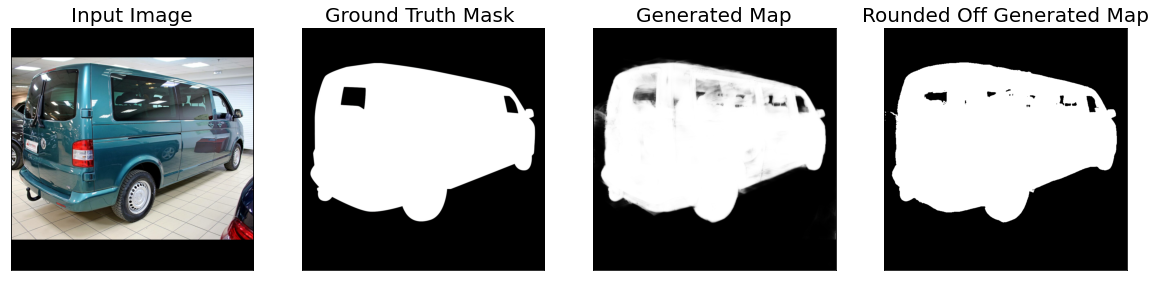

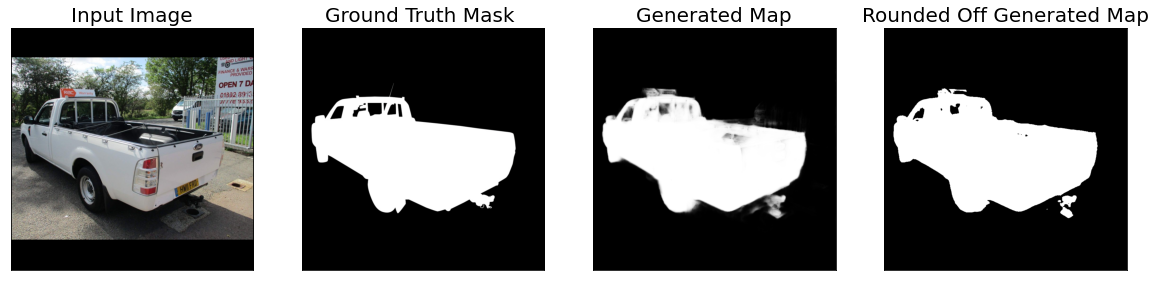

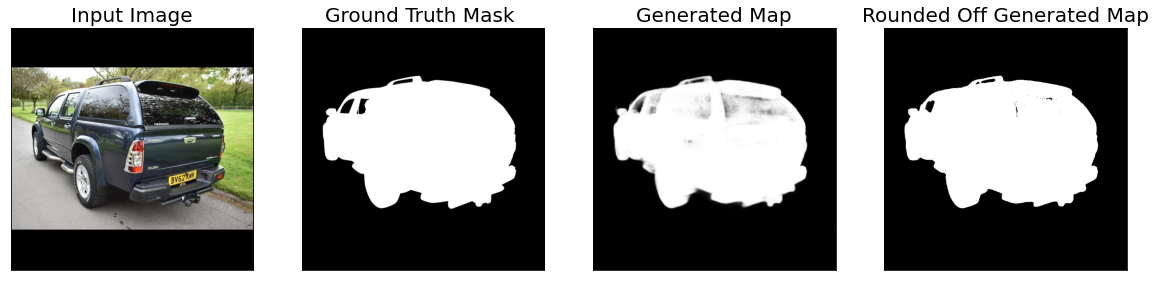

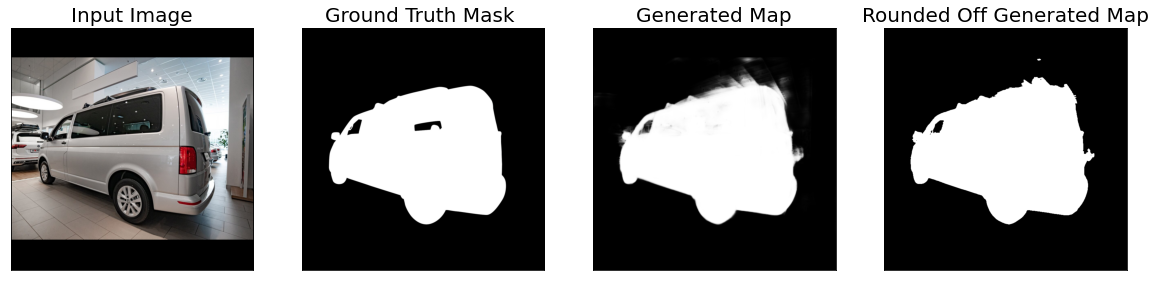

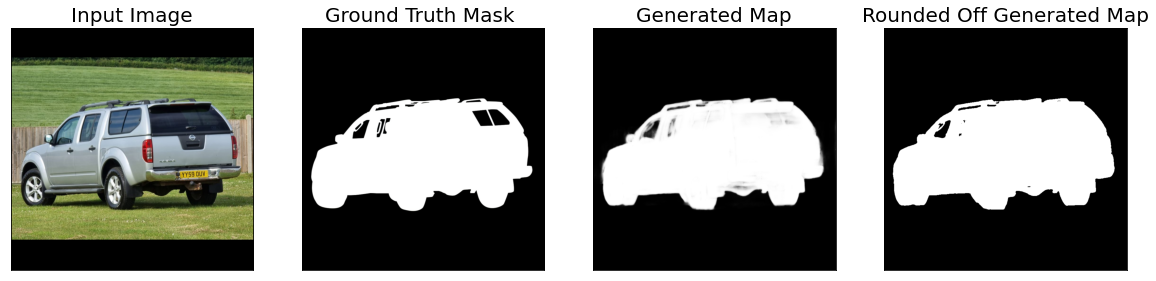

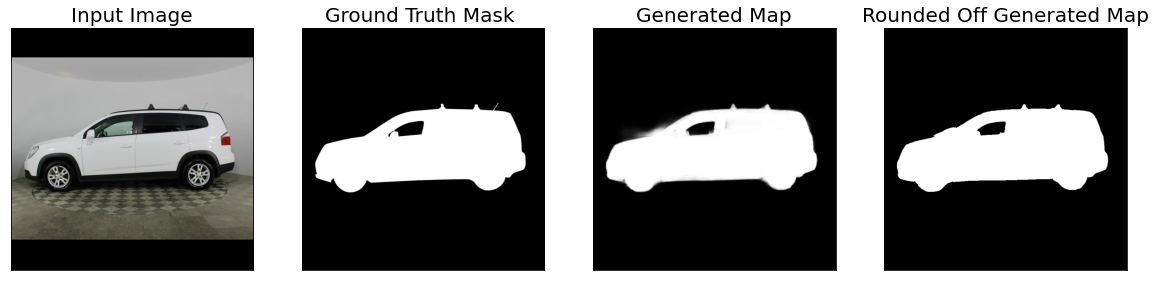

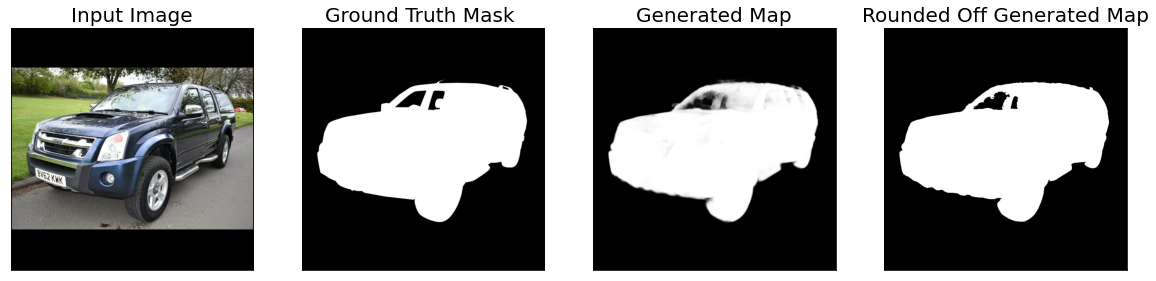

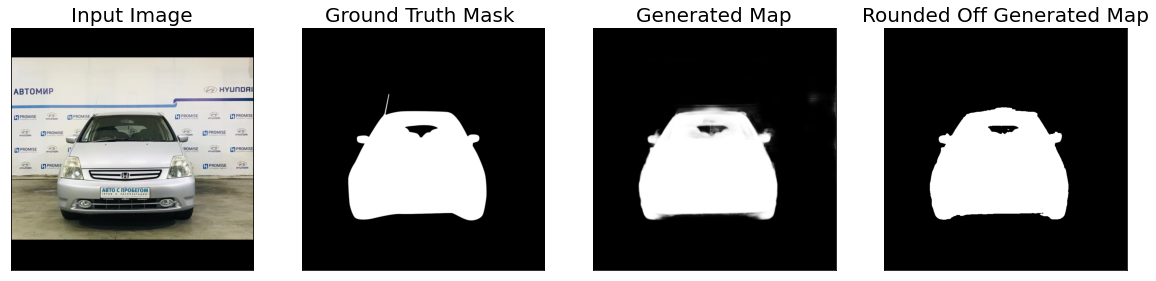

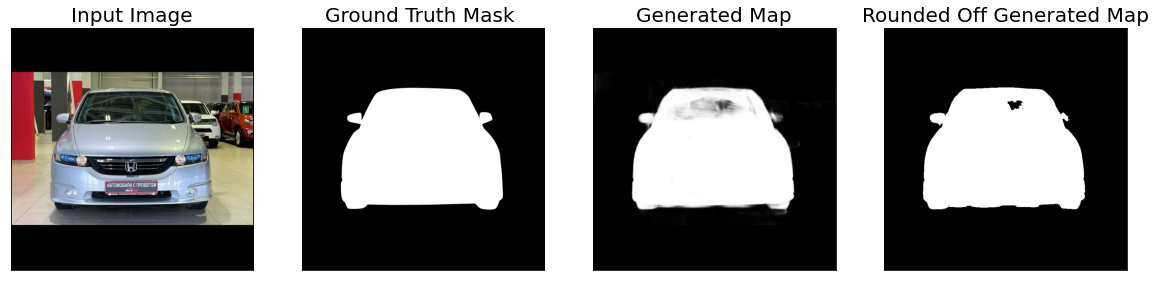

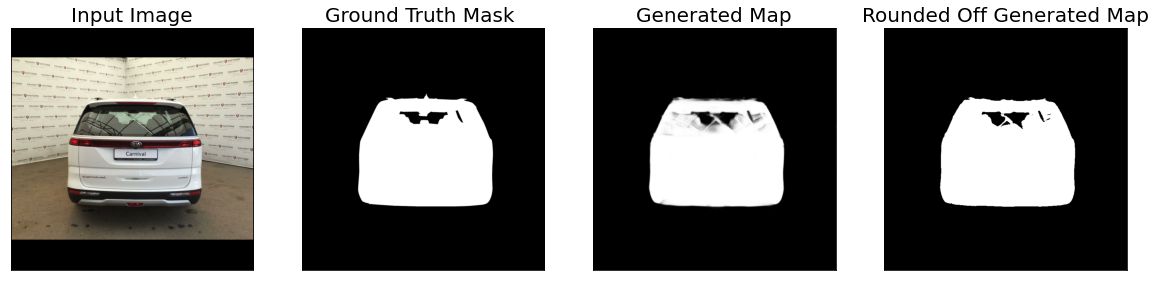

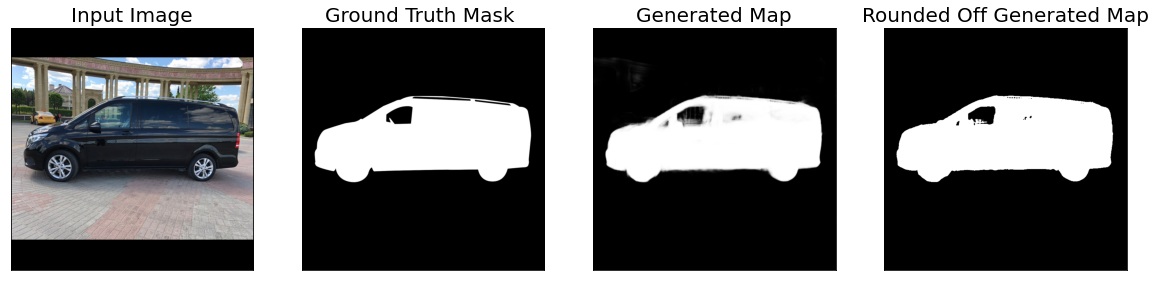

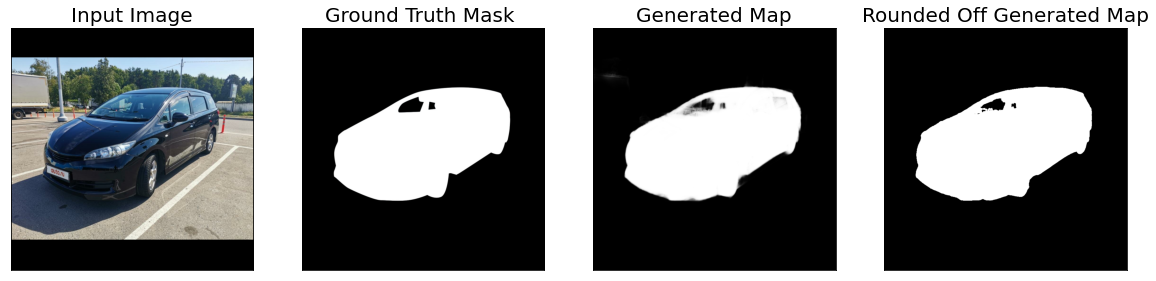

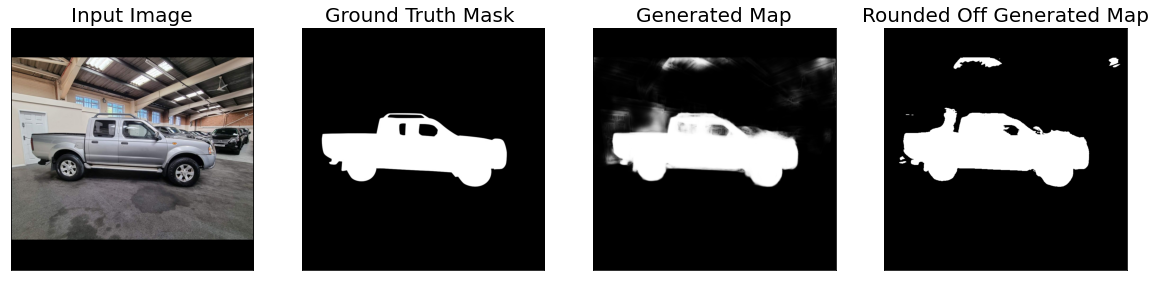

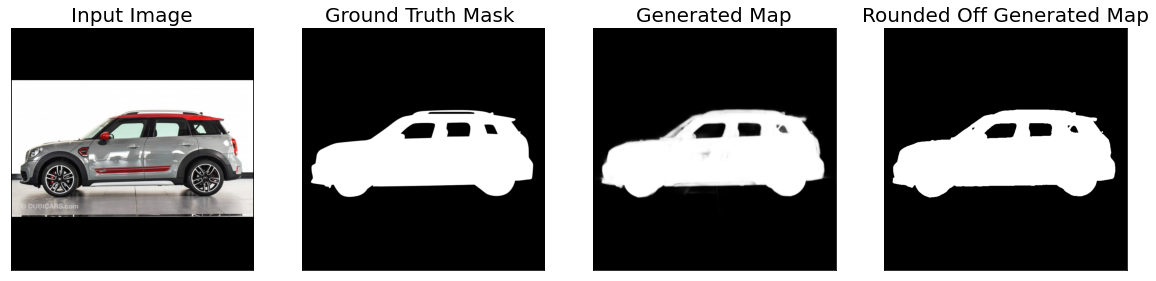

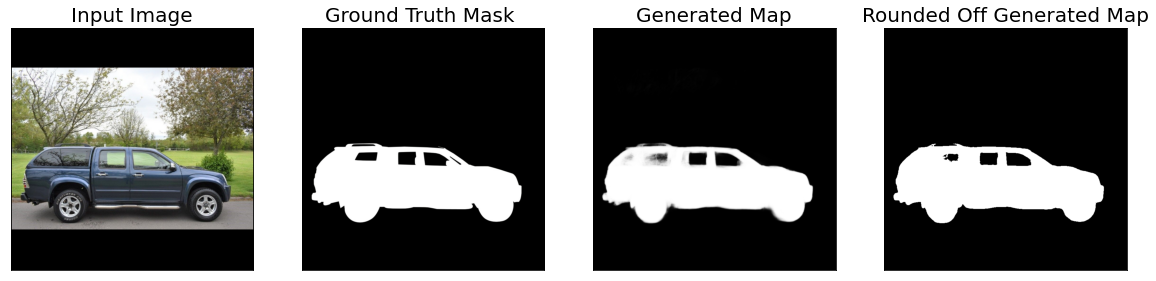

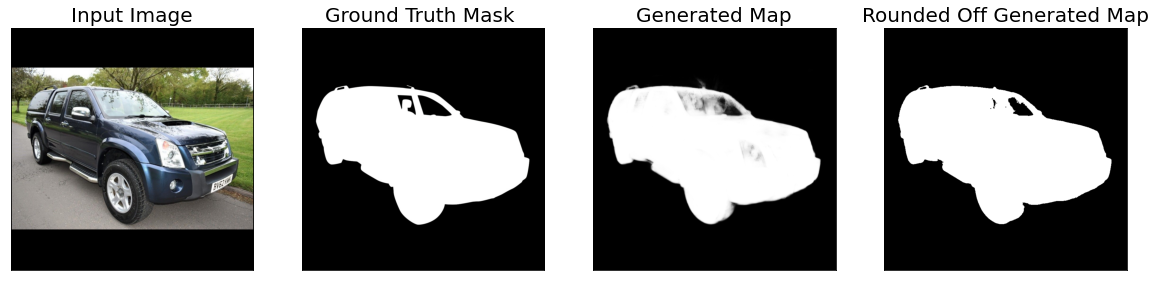

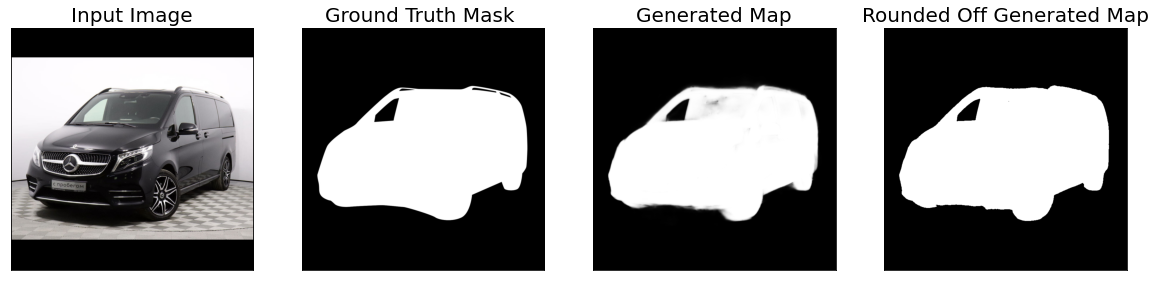

In [14]:
calculate_mae()
run_inference()